# Overview of concepts

In [2]:
# Imports 
import numpy as np 
from matplotlib import pyplot 
%matplotlib inline

## 1/f noise 

The most commonly encountered form of noise is white-noise. White-noise describes random, gaussian distributed variations that have all the typical statistical properties you might expect. For example for a set of random variables $x$ drawn from a white noise distribution the mean is 
$$
\left<x\right> = \frac{\sum{x}}{N}, 
$$
and the variance is 
$$
\sigma^2 = \left<x^2\right> - \left<x\right>^2 
$$
If you were to measure the power spectrum of $x$ (by taking the sqaure of the fourier transform) you would find that the power spectrum is flat. This is the example shown in the third plot below where $alpha = 0$. 

1/f noise is a more general description for noise. It describes noise that have power spectra that can be described as 
$$
P(\nu) = \sigma^2 \left(\frac{\nu}{\nu_k}\right)^\alpha, 
$$
where $alpha$ is the spectral index ($alpha = 0$ is white noise), $\sigma^2$ is the variance of the noise as the fourier frequency $\nu_k$. If you generate noise with $\alpha <0$ you get correlations between the samples of $x$. Some interesting properties of this noise is that the variance is $\sigma^2 = \infty$ at $N = \infty$, which means that as $N$ increases, the variance will increase.

Referenecs:
- Chapter 4 of Tools of Radio Astronomy
- 1/f noise and other systematic effects in the Planck-LFI radiometers: https://arxiv.org/abs/astro-ph/0206093 

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


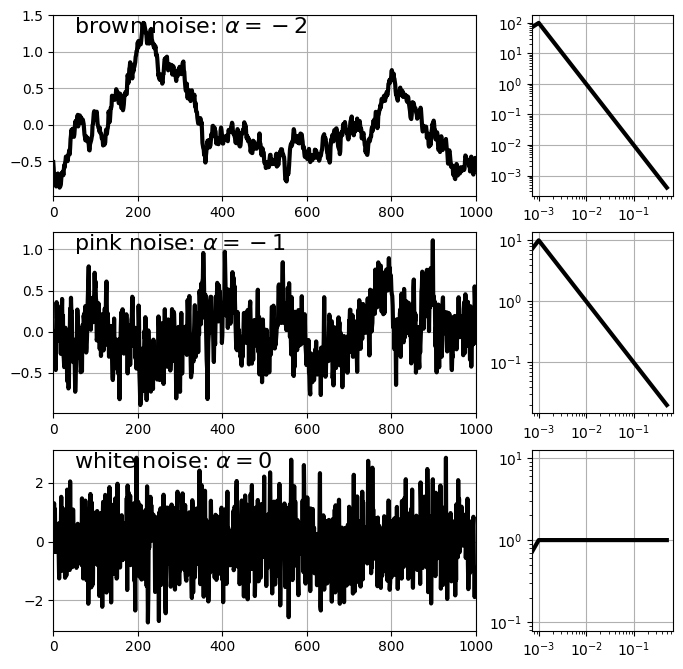

In [24]:
def generate_fnoise(alpha, rms=1, N=1000, nu0=1):
    """Generate 1/f noise 
    
    alpha - spectral index of noise
    """
    wn = np.random.normal(size=N, scale=rms)

    # Fourier transform white noise
    f_wn = np.fft.fft(wn)
    nu = np.fft.fftfreq(N)
    
    power_spectrum = np.zeros_like(f_wn)

    # Avoid division by zero, ignore index 0
    power_spectrum[1:] = np.abs(nu[1:]/nu0)**(alpha) 

    # Multiply white noise by sqrt of power spectrum
    f_noise = f_wn * power_spectrum**0.5

    # Inverse Fourier transform
    noise = np.fft.ifft(f_noise)

    ps = power_spectrum[:N//2]
    nu = nu[:N//2]
    return noise.real, nu, ps 

alphas = [-2,-1,0]
names  = ['brown','pink','white']

fig, axes = pyplot.subplots(3,2,width_ratios=[3, 1],figsize=(8,8))
axes = axes.flatten()
print(axes)

for i, (alpha, name) in enumerate(zip(alphas, names)):
    noise, nu, ps = generate_fnoise(alpha,nu0=0.01)
    pyplot.sca(axes[2*i])
    pyplot.plot(noise, 'k', lw=3)
    pyplot.grid() 
    pyplot.text(0.05, 0.9, r'{} noise: $\alpha = {}$'.format(name, alpha), transform=pyplot.gca().transAxes, fontsize=16)
    pyplot.xlim(0,noise.size)
    pyplot.sca(axes[2*i+1])
    pyplot.plot(nu, ps, 'k', lw=3)
    pyplot.grid() 
    pyplot.xscale('log')
    pyplot.yscale('log') 

pyplot.show()

## 1/f noise in maps 

The effect of 1/f noise in maps is shown below. To create a map from radio telescope data like COMAP we first define the data in terms of the map like this: 
$$
x = Pm + n
$$
where $P$ is called a pointing matrix and contains 1's and 0's with dimensions (N_data, N_pixels), $x$ is the set of measured data (N_data, 1); and $n$ is the noise added to the system from the telescope or atmosphere. 

To create a map of we use something called the map making equation:
$$
\hat{m} = $(P^T N^{-1} P)^{-1} P^T N^{-1} x
$$
$N = E(n n^T)$ is the noise matrix, which is diagonal for white noise ($\alpha=0$) or a dense toeplitz-like matrix if $\alpha < 0$. $\hat{m}$ is the maximum likelihood estimate of the map. If the noise is white then this equation is just the weighted average of the data in each pixel. 



0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
0 24 24
0 25 25
0 26 26
0 27 27
0 28 28
0 29 29
1 0 30
1 1 31
1 2 32
1 3 33
1 4 34
1 5 35
1 6 36
1 7 37
1 8 38
1 9 39
1 10 40
1 11 41
1 12 42
1 13 43
1 14 44
1 15 45
1 16 46
1 17 47
1 18 48
1 19 49
1 20 50
1 21 51
1 22 52
1 23 53
1 24 54
1 25 55
1 26 56
1 27 57
1 28 58
1 29 59
2 0 60
2 1 61
2 2 62
2 3 63
2 4 64
2 5 65
2 6 66
2 7 67
2 8 68
2 9 69
2 10 70
2 11 71
2 12 72
2 13 73
2 14 74
2 15 75
2 16 76
2 17 77
2 18 78
2 19 79
2 20 80
2 21 81
2 22 82
2 23 83
2 24 84
2 25 85
2 26 86
2 27 87
2 28 88
2 29 89
3 0 90
3 1 91
3 2 92
3 3 93
3 4 94
3 5 95
3 6 96
3 7 97
3 8 98
3 9 99
3 10 100
3 11 101
3 12 102
3 13 103
3 14 104
3 15 105
3 16 106
3 17 107
3 18 108
3 19 109
3 20 110
3 21 111
3 22 112
3 23 113
3 24 114
3 25 115
3 26 116
3 27 117
3 28 118
3 29 119
4 0 120
4 1 121
4 2 122
4 3 123
4 4 124
4 5 125
4 6 126
4 7 127
4 8 12

Text(0.05, 0.9, '$\\alpha = 0$')

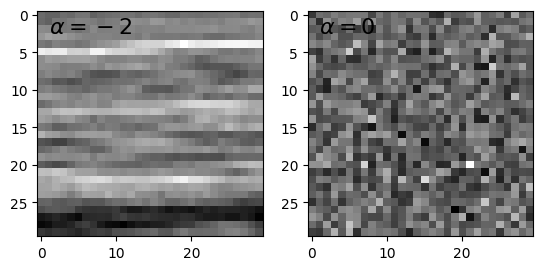

In [33]:
def create_image(noise, imgx=256, imgy=256):
    """Create an image from a 1D array of noise"""
    image = np.zeros((imgx, imgy))
    counts = np.zeros((imgx, imgy))
    for i in range(noise.size):
        x = (i // imgy) % imgx
        y = i % imgy
        print(x,y,i)
        if x == 10:
            print(i, imgy, x)
        image[x,y] += noise[i]
        counts[x,y] += 1
    image[counts > 0] /= counts[counts > 0]
    return image

noise, nu, ps = generate_fnoise(-2, nu0=0.01)
image = create_image(noise,imgx=30,imgy=30)
ax = pyplot.subplot(121)
pyplot.imshow(image, cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = -2$', transform=ax.transAxes, fontsize=16)
ax = pyplot.subplot(122)
noise, nu, ps = generate_fnoise(0, nu0=0.01)
pyplot.imshow(create_image(noise,imgx=30,imgy=30), cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = 0$', transform=ax.transAxes, fontsize=16)
